# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 4 #0 for 0.5, 1 for isolated, 2 for random, 3 for best, 4 for sim_anneal

global threshold
threshold = 20 

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zbranin
    global xx,yy
    global Big_df
    global Big_df_land
    global clf


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zbranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zbranin.append(braninColor(branincoords[i],threshold))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zbranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [4]:
def StaticPen(x):

    if(wales.contains_point(x)):
        pen = 1
    else:
        pen = 0

    dist = (tree.query([x], k=1)[0])
    prob = clf.predict_proba([x])[0][0]
    tmp_score = (0.5-np.abs(0.5-prob))*dist

    return tmp_score*pen

def sim_anneal_best():
    
    global tree
    
    tree = KDTree(X, leaf_size=40)

    lower_bound = np.array([-5,-2])
    upper_bound = np.array([51,53])
    max_iter = 1000
    stdevscale = 0.2*(upper_bound-lower_bound)
    gamma = 0.35
    t_initial = 1000
    r = 100
    beta = 1

    import math
    from scipy.stats import truncnorm
    global Xdash,Ydash




    Xbest = np.random.uniform(low  = lower_bound,    
                          high = upper_bound,        
                          size = (len(lower_bound)))

    Ybest = StaticPen(Xbest)
    Xcenter = Xbest                                          
    Ycenter = Ybest
    t_k=t_initial

    for k in range(max_iter-1):  

        Xdash = truncnorm.rvs((lower_bound - Xcenter)/stdevscale,(upper_bound-Xcenter)    
                              /stdevscale,loc=Xcenter,scale=stdevscale)          

        Ydash = StaticPen(Xdash)
        deltaY = Ydash - Ycenter

        if deltaY<=0 or np.random.rand()<min((math.exp(-deltaY/t_k)),1):
            Xcenter = Xdash
            Ycenter = Ydash                               

            if Ydash>Ybest:
                Xbest=Xdash
                Ybest=Ydash

                t_k = t_k*gamma    

    ax.scatter(Xbest[0],Xbest[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
    print('sim_anneal_isolated coord:',(Xbest[0],Xbest[1]),'distance:',Ybest)
    
    return np.array([Xbest[0],Xbest[1]])

In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

In [7]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


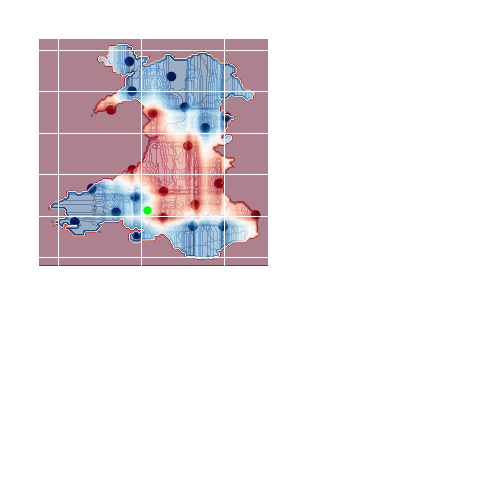

iteration  1
Accuracy is 0.4306864064602961
sim_anneal_isolated coord: (3.987084328656702, 8.551101835207831) distance: [[16.40828456]]
iteration  2
Accuracy is 0.5533551240146126
sim_anneal_isolated coord: (32.40963622655387, 7.490071151046074) distance: [[8.55200283]]
iteration  3
Accuracy is 0.6081522784079985
sim_anneal_isolated coord: (40.572370697902215, 33.77822509714467) distance: [[5.5825962]]
iteration  4
Accuracy is 0.6685252835993079
sim_anneal_isolated coord: (17.836519379679533, 21.070332897068067) distance: [[4.95621841]]
iteration  5
Accuracy is 0.7258219573159008
sim_anneal_isolated coord: (12.693401634961008, 35.51793293895186) distance: [[7.36115341]]
iteration  6
Accuracy is 0.6923668525283599
sim_anneal_isolated coord: (18.971004000714892, 5.508587318811078) distance: [[4.6185357]]
iteration  7
Accuracy is 0.6671793885791194
sim_anneal_isolated coord: (17.118177788172098, 47.18528846962317) distance: [[4.83986057]]
iteration  8
Accuracy is 0.7240915208613729
sim_an

<IPython.core.display.Javascript object>


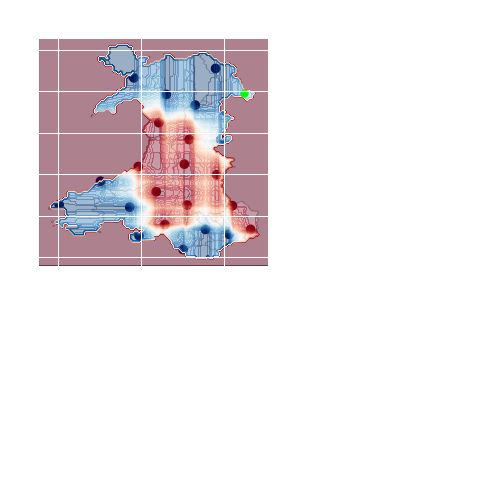

iteration  1
Accuracy is 0.45991155547010193
sim_anneal_isolated coord: (18.200092590903125, 43.24198653576271) distance: [[15.55646554]]
iteration  2
Accuracy is 0.5443184003076331
sim_anneal_isolated coord: (37.893584297804736, 45.497733145554804) distance: [[9.514685]]
iteration  3
Accuracy is 0.6250721015189387
sim_anneal_isolated coord: (0.21593151645566921, 12.666918908166128) distance: [[8.56999552]]
iteration  4
Accuracy is 0.6169967313978081
sim_anneal_isolated coord: (39.15253584411882, 28.32826642516853) distance: [[6.77384309]]
iteration  5
Accuracy is 0.6243030186502596
sim_anneal_isolated coord: (17.21955015384561, 12.104976466033069) distance: [[3.94010045]]
iteration  6
Accuracy is 0.631609305902711
sim_anneal_isolated coord: (41.13616486534737, 5.56793893215282) distance: [[3.39297436]]
iteration  7
Accuracy is 0.6360315323976159
sim_anneal_isolated coord: (31.052822650505483, 12.586743881606402) distance: [[2.79313891]]
iteration  8
Accuracy is 0.7194770236492982
sim_

<IPython.core.display.Javascript object>


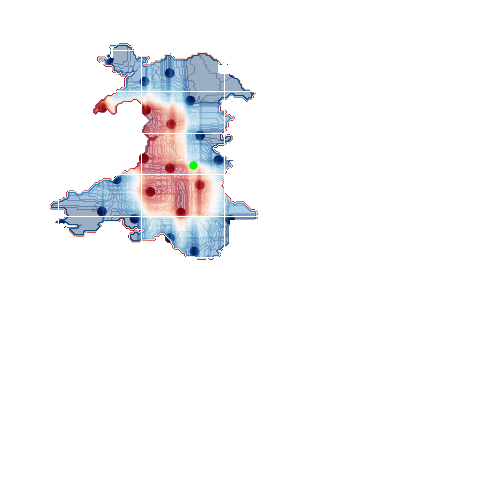

iteration  1
Accuracy is 0.45414343395500867
sim_anneal_isolated coord: (42.25527034241797, 44.396735419161004) distance: [[17.29522804]]
iteration  2
Accuracy is 0.5837338973274371
sim_anneal_isolated coord: (12.18246417021835, 47.68579103534995) distance: [[13.31093857]]
iteration  3
Accuracy is 0.7123630071140166
sim_anneal_isolated coord: (27.1902184552879, 32.06092529044892) distance: [[9.73560476]]
iteration  4
Accuracy is 0.645260526821765
sim_anneal_isolated coord: (0.9983895809891221, 7.793171844220813) distance: [[12.89811473]]
iteration  5
Accuracy is 0.7167852336089213
sim_anneal_isolated coord: (14.064283518651141, 18.775659239590663) distance: [[6.99807205]]
iteration  6
Accuracy is 0.7413958854066526
sim_anneal_isolated coord: (38.59771120867292, 23.431187202657064) distance: [[5.86462358]]
iteration  7
Accuracy is 0.7660065372043837
sim_anneal_isolated coord: (26.852318090452982, 44.38039193385891) distance: [[5.91556789]]
iteration  8
Accuracy is 0.7390886368006153
sim

<IPython.core.display.Javascript object>


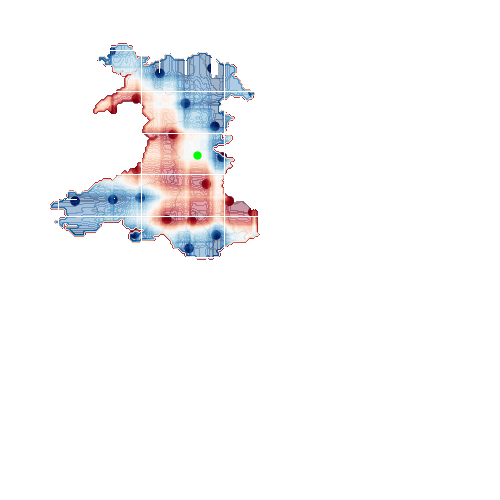

iteration  1
Accuracy is 0.4875985387425495
sim_anneal_isolated coord: (37.04484083828914, 45.560795948175965) distance: [[17.50495541]]
iteration  2
Accuracy is 0.5904633724283792
sim_anneal_isolated coord: (46.8467590574063, 10.848646216796078) distance: [[10.19607635]]
iteration  3
Accuracy is 0.5621995770044222
sim_anneal_isolated coord: (27.642962860266344, 29.627707799337557) distance: [[7.40009305]]
iteration  4
Accuracy is 0.6804460680638339
sim_anneal_isolated coord: (18.84101627499126, 21.045961069705367) distance: [[5.5319011]]
iteration  5
Accuracy is 0.6285329744279946
sim_anneal_isolated coord: (12.686403197495222, 49.711346926162896) distance: [[10.62509516]]
iteration  6
Accuracy is 0.6712170736396846
sim_anneal_isolated coord: (13.057930282481781, 35.51017117582673) distance: [[6.67683636]]
iteration  7
Accuracy is 0.6254566429532782
sim_anneal_isolated coord: (46.947539323676416, 39.64717627964512) distance: [[5.76702555]]
iteration  8
Accuracy is 0.6519900019227072
s

<IPython.core.display.Javascript object>


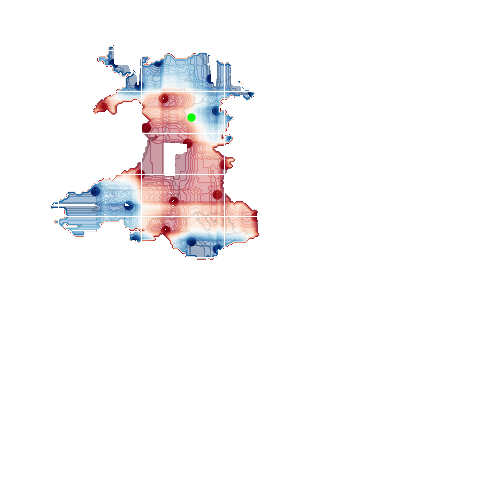

iteration  1
Accuracy is 0.6300711401653528
sim_anneal_isolated coord: (38.39086461279844, 1.9721026927158185) distance: [[10.85160627]]
iteration  2
Accuracy is 0.5464333781965006
sim_anneal_isolated coord: (13.304848293036887, 46.631330301474605) distance: [[9.77112744]]
iteration  3
Accuracy is 0.8200346087290905
sim_anneal_isolated coord: (8.956935685666302, 15.864512921371883) distance: [[7.02202165]]
iteration  4
Accuracy is 0.7221688136896751
sim_anneal_isolated coord: (27.83811659547834, 13.459871734791125) distance: [[6.90406428]]
iteration  5
Accuracy is 0.801768890597962
sim_anneal_isolated coord: (25.36331479501237, 38.25379995027816) distance: [[6.14273245]]
iteration  6
Accuracy is 0.7679292443760816
sim_anneal_isolated coord: (19.74065612253422, 19.996021850811275) distance: [[4.89093943]]
iteration  7
Accuracy is 0.7135166314170351
sim_anneal_isolated coord: (10.793353529357345, 36.21078070493099) distance: [[4.28757199]]
iteration  8
Accuracy is 0.6810228802153432
sim_

<IPython.core.display.Javascript object>


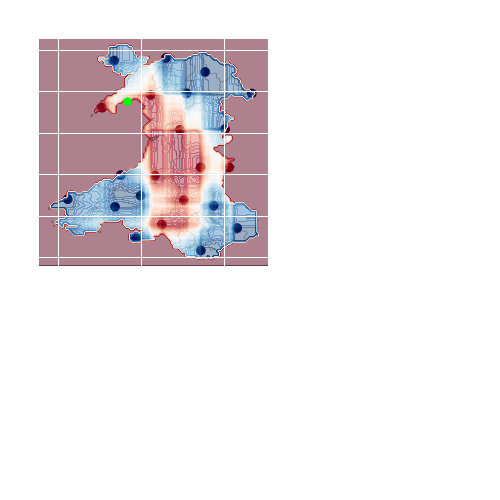

iteration  1
Accuracy is 0.4427994616419919
sim_anneal_isolated coord: (35.3719016247187, 44.655219005608906) distance: [[12.49164252]]
iteration  2
Accuracy is 0.5945010574889444
sim_anneal_isolated coord: (29.27487511566821, 30.744523196119353) distance: [[6.29729219]]
iteration  3
Accuracy is 0.562391847721592
sim_anneal_isolated coord: (13.464304360364252, 47.405307065511224) distance: [[7.50704141]]
iteration  4
Accuracy is 0.7381272832147664
sim_anneal_isolated coord: (2.268136570031291, 14.019958709762173) distance: [[10.44485441]]
iteration  5
Accuracy is 0.7973466641030571
sim_anneal_isolated coord: (24.928255883700796, 7.9037246497107425) distance: [[5.81995888]]
iteration  6
Accuracy is 0.7446644875985388
sim_anneal_isolated coord: (34.34377695417446, 1.667747368698147) distance: [[5.49207776]]
iteration  7
Accuracy is 0.7596616035377812
sim_anneal_isolated coord: (13.672930997067668, 12.176102600682853) distance: [[4.62115382]]
iteration  8
Accuracy is 0.790617189002115
sim

<IPython.core.display.Javascript object>


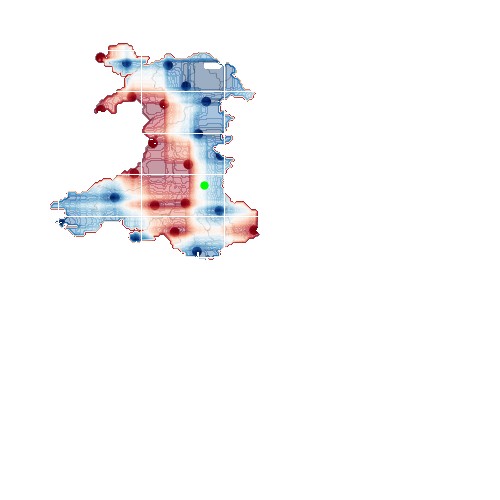

iteration  1
Accuracy is 0.4883676216112286
sim_anneal_isolated coord: (0.519441906074841, 8.303523600279867) distance: [[14.63083689]]
iteration  2
Accuracy is 0.6642953278215727
sim_anneal_isolated coord: (35.64884622686605, 37.519439737263) distance: [[8.52908765]]
iteration  3
Accuracy is 0.7971543933858873
sim_anneal_isolated coord: (47.164578010064446, 6.559571111595968) distance: [[7.98240873]]
iteration  4
Accuracy is 0.691405498942511
sim_anneal_isolated coord: (22.828680000040933, 27.50577049661785) distance: [[7.32035671]]
iteration  5
Accuracy is 0.7437031340126898
sim_anneal_isolated coord: (13.630035546729426, 14.394152457797855) distance: [[6.50531657]]
iteration  6
Accuracy is 0.7829263603153239
sim_anneal_isolated coord: (18.43540223785673, 4.59837347898314) distance: [[5.34636561]]
iteration  7
Accuracy is 0.858104210728706
sim_anneal_isolated coord: (39.125551050538036, 24.54893705749978) distance: [[6.7141905]]
iteration  8
Accuracy is 0.8175350894058835
sim_anneal_

<IPython.core.display.Javascript object>


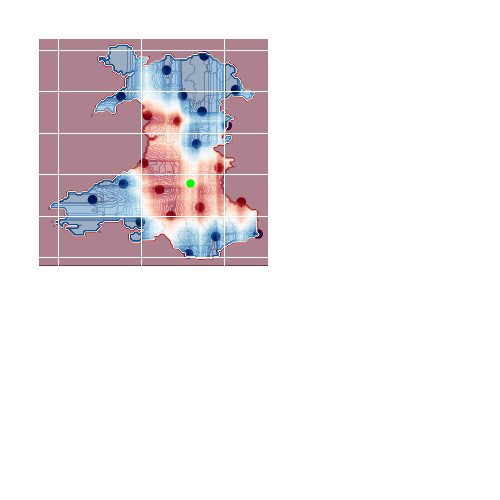

iteration  1
Accuracy is 0.6183426264179965
sim_anneal_isolated coord: (48.132253014589025, 5.642273994632523) distance: [[12.74798464]]
iteration  2
Accuracy is 0.7237069794270332
sim_anneal_isolated coord: (15.106377992320413, 38.75246261145766) distance: [[10.49177798]]
iteration  3
Accuracy is 0.7458181119015574
sim_anneal_isolated coord: (8.261874199665467, 13.886931525803629) distance: [[8.16824029]]
iteration  4
Accuracy is 0.7883099403960777
sim_anneal_isolated coord: (38.71214276399102, 21.612060805028328) distance: [[7.16342016]]
iteration  5
Accuracy is 0.8038838684868295
sim_anneal_isolated coord: (31.365380967390134, 0.8503727523958062) distance: [[7.12815395]]
iteration  6
Accuracy is 0.7815804652951356
sim_anneal_isolated coord: (28.855914987841164, 32.790394487890026) distance: [[6.85539483]]
iteration  7
Accuracy is 0.7362045760430687
sim_anneal_isolated coord: (42.73747173262357, 40.38721955180423) distance: [[5.34753848]]
iteration  8
Accuracy is 0.7725437415881561
s

<IPython.core.display.Javascript object>


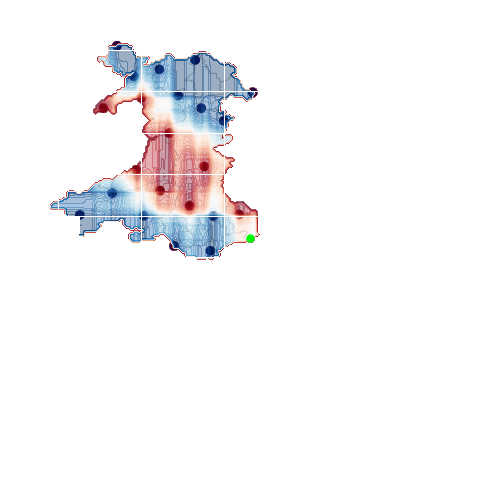

iteration  1
Accuracy is 0.5202845606614113
sim_anneal_isolated coord: (14.13866985706543, 50.940609181733144) distance: [[14.3441514]]
iteration  2
Accuracy is 0.5831570851759277
sim_anneal_isolated coord: (27.903432377181282, 2.790123523900844) distance: [[10.21572443]]
iteration  3
Accuracy is 0.5506633339742357
sim_anneal_isolated coord: (32.99100974978499, 47.54739683398489) distance: [[9.00297985]]
iteration  4
Accuracy is 0.5887329359738512
sim_anneal_isolated coord: (43.532015355332916, 10.315687703521917) distance: [[6.28449644]]
iteration  5
Accuracy is 0.5614304941357431
sim_anneal_isolated coord: (34.44838368796829, 35.94305574565208) distance: [[5.14601907]]
iteration  6
Accuracy is 0.6373774274178042
sim_anneal_isolated coord: (46.82684907480911, 39.725676418898956) distance: [[5.17740668]]
iteration  7
Accuracy is 0.6416073831955393
sim_anneal_isolated coord: (18.845991324144485, 21.070950508173517) distance: [[6.04436279]]
iteration  8
Accuracy is 0.729090559507787
sim_

<IPython.core.display.Javascript object>


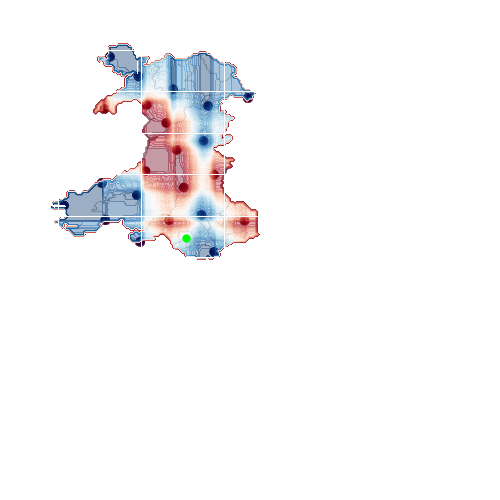

iteration  1
Accuracy is 0.579503941549702
sim_anneal_isolated coord: (1.4237748708033138, 12.490309610937732) distance: [[9.14902305]]
iteration  2
Accuracy is 0.7390886368006153
sim_anneal_isolated coord: (36.089366572201364, 36.47648347299906) distance: [[8.73569053]]
iteration  3
Accuracy is 0.7388963660834454
sim_anneal_isolated coord: (19.71228750695169, 3.788822990484343) distance: [[7.66765213]]
iteration  4
Accuracy is 0.800807537012113
sim_anneal_isolated coord: (37.55153536209201, 19.900368041732353) distance: [[8.11175444]]
iteration  5
Accuracy is 0.8256104595270141
sim_anneal_isolated coord: (34.498334237151255, 10.221924391447862) distance: [[4.56687502]]
iteration  6
Accuracy is 0.7388963660834454
sim_anneal_isolated coord: (44.880293820522446, 8.82928883402537) distance: [[5.02797465]]
iteration  7
Accuracy is 0.7879253989617381
sim_anneal_isolated coord: (26.001205862847037, 32.38128179466789) distance: [[5.44384201]]
iteration  8
Accuracy is 0.7825418188809844
sim_an

<IPython.core.display.Javascript object>


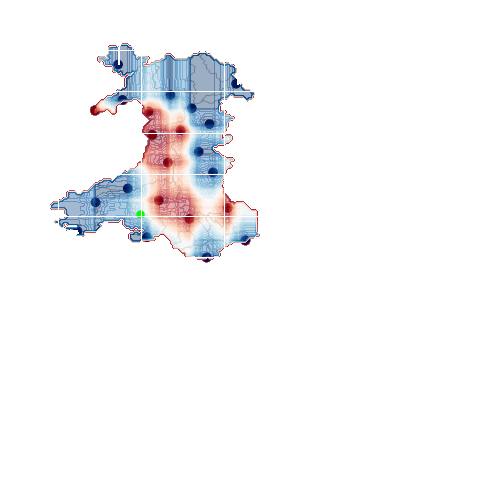

iteration  1
Accuracy is 0.49894251105556625
sim_anneal_isolated coord: (14.408184105674328, 46.45241429186014) distance: [[17.75761699]]
iteration  2
Accuracy is 0.6243030186502596
sim_anneal_isolated coord: (42.829398300429204, 41.81451305689182) distance: [[13.82262947]]
iteration  3
Accuracy is 0.6873678138819458
sim_anneal_isolated coord: (26.42079646638341, 22.852421815187114) distance: [[8.86729025]]
iteration  4
Accuracy is 0.7121707363968468
sim_anneal_isolated coord: (21.33864493200304, 4.885949842577002) distance: [[8.22465198]]
iteration  5
Accuracy is 0.745241299750048
sim_anneal_isolated coord: (27.020317795483955, 39.08423188558036) distance: [[6.57302029]]
iteration  6
Accuracy is 0.7765814266487214
sim_anneal_isolated coord: (36.4355760382915, 32.10131919518852) distance: [[5.23292341]]
iteration  7
Accuracy is 0.800807537012113
sim_anneal_isolated coord: (16.729490985559774, 16.585430531587086) distance: [[4.96266541]]
iteration  8
Accuracy is 0.7588925206691021
sim_a

<IPython.core.display.Javascript object>


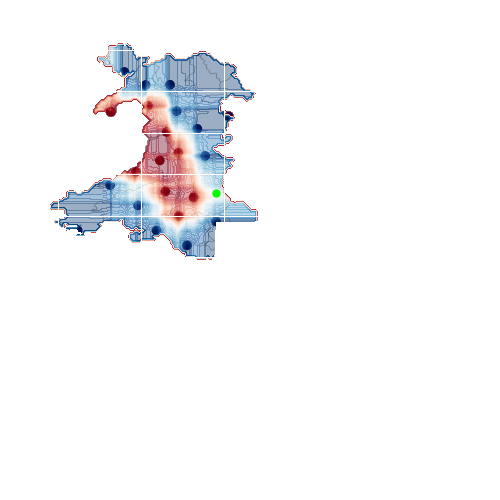

iteration  1
Accuracy is 0.5618150355700827
sim_anneal_isolated coord: (4.687939158407951, 6.47727640845962) distance: [[14.07157347]]
iteration  2
Accuracy is 0.6056527590847914
sim_anneal_isolated coord: (38.03239827856811, 8.64025036763736) distance: [[9.86223967]]
iteration  3
Accuracy is 0.6773697365891175
sim_anneal_isolated coord: (25.78701377188224, 15.913088424164064) distance: [[6.83631252]]
iteration  4
Accuracy is 0.7114016535281676
sim_anneal_isolated coord: (41.01319932334451, 33.978361456958325) distance: [[7.68408801]]
iteration  5
Accuracy is 0.8319553931936167
sim_anneal_isolated coord: (12.505518202238889, 17.40639362299621) distance: [[5.88068]]
iteration  6
Accuracy is 0.8113824264564506
sim_anneal_isolated coord: (35.36192961354956, 24.43269143028905) distance: [[5.23830023]]
iteration  7
Accuracy is 0.781195923860796
sim_anneal_isolated coord: (26.922347646279995, 41.573068840443746) distance: [[5.00711191]]
iteration  8
Accuracy is 0.7706210344164584
sim_anneal_

<IPython.core.display.Javascript object>


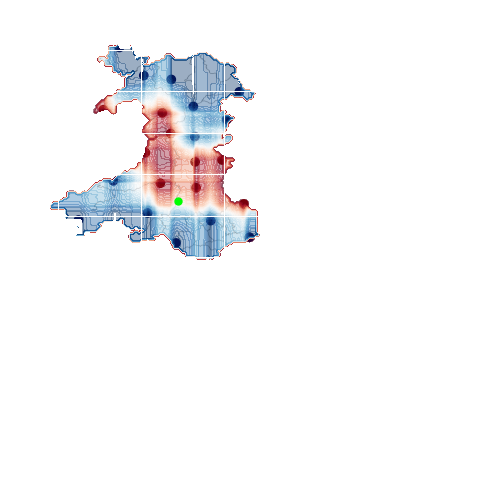

iteration  1
Accuracy is 0.5739280907517785
sim_anneal_isolated coord: (36.72850222744454, 8.850411271735226) distance: [[10.10352315]]
iteration  2
Accuracy is 0.5047106325706595
sim_anneal_isolated coord: (4.884490678153341, 9.005488391509777) distance: [[8.92191493]]
iteration  3
Accuracy is 0.6310324937512017
sim_anneal_isolated coord: (14.738633794615016, 50.56394689219233) distance: [[12.27106149]]
iteration  4
Accuracy is 0.6919823110940204
sim_anneal_isolated coord: (21.50311041895052, 10.68947881645878) distance: [[6.25252835]]
iteration  5
Accuracy is 0.6529513555085561
sim_anneal_isolated coord: (20.604800733989624, 43.80801385271637) distance: [[4.4736603]]
iteration  6
Accuracy is 0.6419919246298789
sim_anneal_isolated coord: (25.08233993852994, 34.81545103275664) distance: [[2.22565293]]
iteration  7
Accuracy is 0.706787156316093
sim_anneal_isolated coord: (13.253233313040985, 18.427751474249114) distance: [[3.71499477]]
iteration  8
Accuracy is 0.6856373774274178
sim_ann

<IPython.core.display.Javascript object>


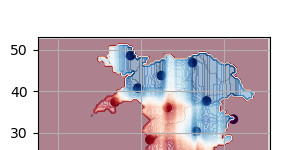

iteration  1
Accuracy is 0.575273985771967
sim_anneal_isolated coord: (42.825309927925346, 4.630874625787586) distance: [[20.89969501]]
iteration  2
Accuracy is 0.5039415497019804
sim_anneal_isolated coord: (17.51527876523715, 10.101809049438806) distance: [[11.65255689]]
iteration  3
Accuracy is 0.5966160353778119
sim_anneal_isolated coord: (2.974557857083745, 15.193724842642546) distance: [[7.54918387]]
iteration  4
Accuracy is 0.5939242453374352
sim_anneal_isolated coord: (17.413938725805657, 48.60898052060743) distance: [[5.41724853]]
iteration  5
Accuracy is 0.620457604306864
sim_anneal_isolated coord: (26.314599438939098, 36.096001291928026) distance: [[4.69590793]]
iteration  6
Accuracy is 0.6354547202461065
sim_anneal_isolated coord: (42.179023423500595, 33.28049170849975) distance: [[7.41166987]]
iteration  7
Accuracy is 0.6558354162661026
sim_anneal_isolated coord: (26.3127448819247, 21.68049886856967) distance: [[6.7752862]]
iteration  8
Accuracy is 0.7783118631032494
sim_an

<IPython.core.display.Javascript object>


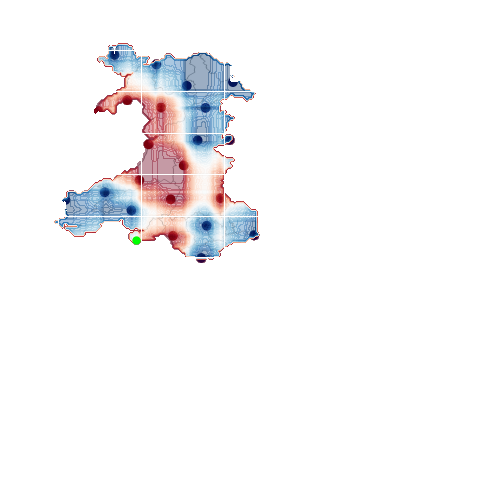

iteration  1
Accuracy is 0.5212459142472602
sim_anneal_isolated coord: (42.0759129710989, 42.21041499662137) distance: [[15.56386264]]
iteration  2
Accuracy is 0.6143049413574313
sim_anneal_isolated coord: (13.553582354168128, 48.76239131593217) distance: [[6.61568796]]
iteration  3
Accuracy is 0.6210344164583734
sim_anneal_isolated coord: (1.7289325142682384, 13.83752460979786) distance: [[6.92014273]]
iteration  4
Accuracy is 0.6227648529129014
sim_anneal_isolated coord: (24.766240460385863, 36.12052487855567) distance: [[4.82750046]]
iteration  5
Accuracy is 0.6758315708517593
sim_anneal_isolated coord: (30.210978800386634, 22.142749996614008) distance: [[7.35038164]]
iteration  6
Accuracy is 0.6865987310132666
sim_anneal_isolated coord: (23.654334548925828, 46.458926206637805) distance: [[4.86923508]]
iteration  7
Accuracy is 0.7419726975581619
sim_anneal_isolated coord: (34.46699163246905, -0.14713601741685878) distance: [[7.74502387]]
iteration  8
Accuracy is 0.7106325706594886
s

<IPython.core.display.Javascript object>


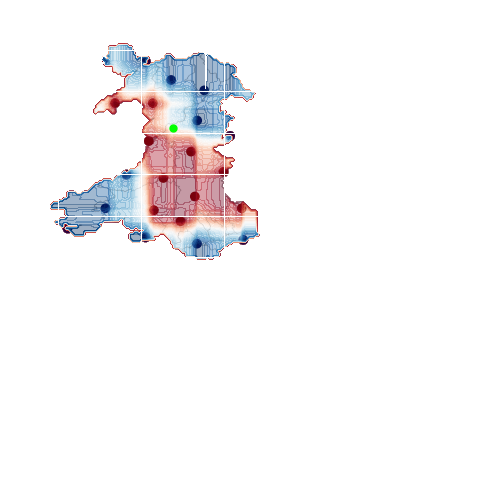

iteration  1
Accuracy is 0.645260526821765
sim_anneal_isolated coord: (10.83594517145754, 47.546905606774075) distance: [[11.43203122]]
iteration  2
Accuracy is 0.7039030955585465
sim_anneal_isolated coord: (2.2517203744845644, 6.96838960196045) distance: [[14.53569902]]
iteration  3
Accuracy is 0.7346664103057104
sim_anneal_isolated coord: (16.427875242057148, 19.911561588928752) distance: [[7.95157019]]
iteration  4
Accuracy is 0.6683330128821381
sim_anneal_isolated coord: (44.560393585464126, 4.212787460661765) distance: [[7.67396814]]
iteration  5
Accuracy is 0.70082676408383
sim_anneal_isolated coord: (31.974819141536276, 25.473935627936342) distance: [[5.09795436]]
iteration  6
Accuracy is 0.7654297250528744
sim_anneal_isolated coord: (23.032147322210932, 11.354914594079341) distance: [[4.891666]]
iteration  7
Accuracy is 0.7956162276485291
sim_anneal_isolated coord: (22.761156595295645, 37.14944931136846) distance: [[5.36570923]]
iteration  8
Accuracy is 0.76062295712363
sim_ann

<IPython.core.display.Javascript object>


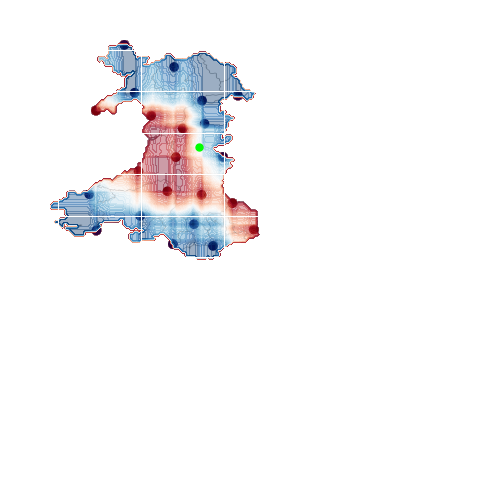

iteration  1
Accuracy is 0.52143818496443
sim_anneal_isolated coord: (47.094835911893114, 6.6789255687933275) distance: [[11.83527435]]
iteration  2
Accuracy is 0.5024033839646221
sim_anneal_isolated coord: (9.098860167107887, 35.3759007209751) distance: [[6.23788929]]
iteration  3
Accuracy is 0.4645260526821765
sim_anneal_isolated coord: (34.52924508039293, 15.056092376530103) distance: [[3.9265251]]
iteration  4
Accuracy is 0.4729859642376466
sim_anneal_isolated coord: (9.182747843190002, 6.495136221056738) distance: [[4.44926201]]
iteration  5
Accuracy is 0.4866371851567006
sim_anneal_isolated coord: (27.625826914926265, 3.1953285455649736) distance: [[5.6266417]]
iteration  6
Accuracy is 0.5472024610651798
sim_anneal_isolated coord: (19.72371465667343, 9.997526305579145) distance: [[5.1090172]]
iteration  7
Accuracy is 0.5266294943280139
sim_anneal_isolated coord: (37.26866475137662, 2.7676357200820596) distance: [[4.53658946]]
iteration  8
Accuracy is 0.5366275716208422
sim_anneal

<IPython.core.display.Javascript object>


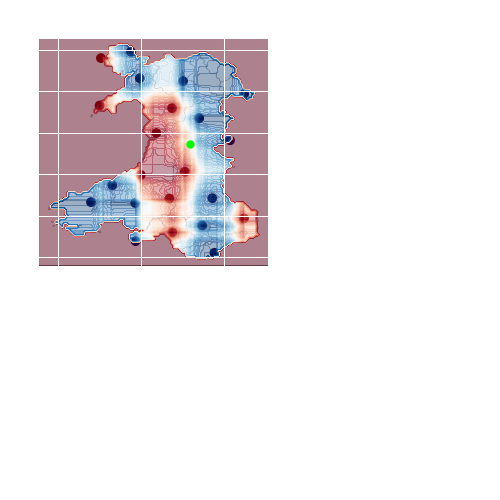

iteration  1
Accuracy is 0.5052874447221688
sim_anneal_isolated coord: (7.880276796728634, 13.305350260583303) distance: [[17.3885202]]
iteration  2
Accuracy is 0.5870024995193233
sim_anneal_isolated coord: (19.63018425882735, 43.150278264592615) distance: [[3.9764549]]
iteration  3
Accuracy is 0.5927706210344165
sim_anneal_isolated coord: (9.944016125887776, 36.565725405758855) distance: [[5.49071927]]
iteration  4
Accuracy is 0.6000769082868679
sim_anneal_isolated coord: (23.619489094052184, 29.954915663226465) distance: [[3.58415585]]
iteration  5
Accuracy is 0.7415881561238223
sim_anneal_isolated coord: (27.48556713455615, 6.0223206130595175) distance: [[9.62059984]]
iteration  6
Accuracy is 0.742741780426841
sim_anneal_isolated coord: (41.37288906789854, 28.20463982008775) distance: [[8.38455072]]
iteration  7
Accuracy is 0.71793885791194
sim_anneal_isolated coord: (44.73537654451262, 9.38237645725511) distance: [[6.32664434]]
iteration  8
Accuracy is 0.7202461065179773
sim_anneal

<IPython.core.display.Javascript object>


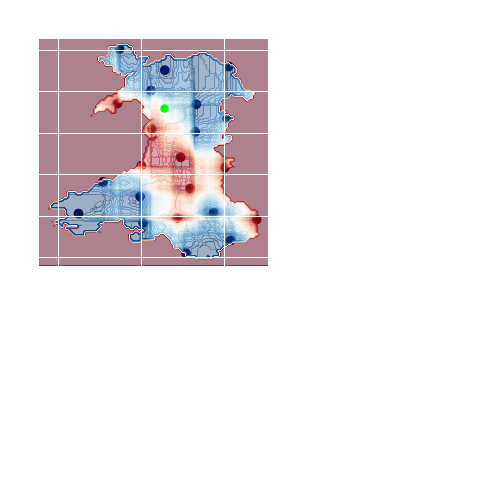

iteration  1
Accuracy is 0.49817342818688715
sim_anneal_isolated coord: (4.8653203637558375, 10.560050830632028) distance: [[12.09170041]]
iteration  2
Accuracy is 0.5235531628532974
sim_anneal_isolated coord: (41.070574351330386, 45.97840900241024) distance: [[9.89496902]]
iteration  3
Accuracy is 0.7356277638915593
sim_anneal_isolated coord: (14.267565149188977, 37.04531559019881) distance: [[8.39448171]]
iteration  4
Accuracy is 0.6448759853874255
sim_anneal_isolated coord: (19.732898256202596, 14.638905848089696) distance: [[6.3964501]]
iteration  5
Accuracy is 0.6056527590847914
sim_anneal_isolated coord: (25.645670152705463, 45.10141243143425) distance: [[6.69186057]]
iteration  6
Accuracy is 0.6842914824072294
sim_anneal_isolated coord: (33.26362165389934, 36.87312668708289) distance: [[5.04598047]]
iteration  7
Accuracy is 0.7344741395885407
sim_anneal_isolated coord: (14.750832046971418, 50.22698758404315) distance: [[4.81612322]]
iteration  8
Accuracy is 0.7156316093059027
si

<IPython.core.display.Javascript object>


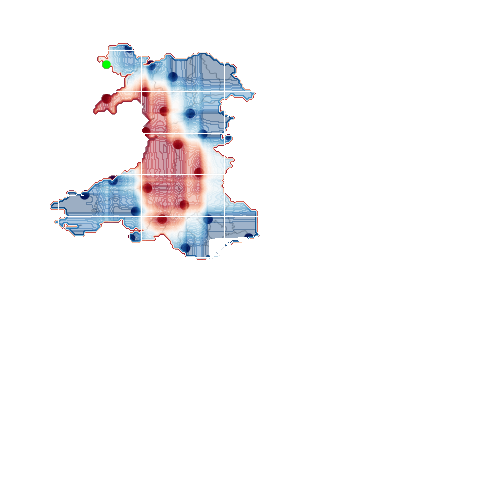

iteration  1
Accuracy is 0.5979619303980004
sim_anneal_isolated coord: (45.930217439715626, 4.620527160663222) distance: [[15.61184164]]
iteration  2
Accuracy is 0.537588925206691
sim_anneal_isolated coord: (17.39249281561271, 4.603608143075897) distance: [[12.67835229]]
iteration  3
Accuracy is 0.7114016535281676
sim_anneal_isolated coord: (6.351909593588585, 15.082083086132151) distance: [[5.78415568]]
iteration  4
Accuracy is 0.685445106710248
sim_anneal_isolated coord: (17.15352331967277, 50.45672465626167) distance: [[9.88830678]]
iteration  5
Accuracy is 0.6977504326091136
sim_anneal_isolated coord: (21.45527466312025, 16.65159872312168) distance: [[6.10299328]]
iteration  6
Accuracy is 0.7537012113055181
sim_anneal_isolated coord: (33.897607570601856, 20.41893990436669) distance: [[5.07006762]]
iteration  7
Accuracy is 0.7915785425879639
sim_anneal_isolated coord: (36.07308400678443, 9.206389551971562) distance: [[5.43583511]]
iteration  8
Accuracy is 0.7996539127090944
sim_anne

<IPython.core.display.Javascript object>


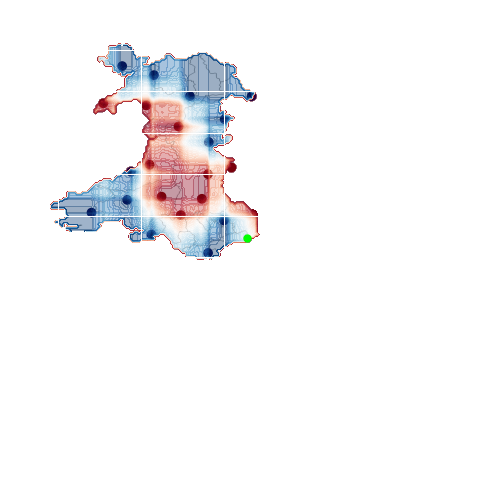

iteration  1
Accuracy is 0.49855796962122667
sim_anneal_isolated coord: (36.07709136458149, 1.0646543299765199) distance: [[6.43382833]]
iteration  2
Accuracy is 0.5814266487213997
sim_anneal_isolated coord: (15.399564381559458, 46.07545573003085) distance: [[18.03143256]]
iteration  3
Accuracy is 0.7767736973658912
sim_anneal_isolated coord: (31.693460710284285, 38.84234964664047) distance: [[8.2005097]]
iteration  4
Accuracy is 0.681215150932513
sim_anneal_isolated coord: (47.652686503651246, 11.065790663614383) distance: [[6.16729661]]
iteration  5
Accuracy is 0.689675062487983
sim_anneal_isolated coord: (22.011322127664926, 22.326155221975654) distance: [[6.312029]]
iteration  6
Accuracy is 0.7979234762545664
sim_anneal_isolated coord: (22.44553460491972, 5.502501162248004) distance: [[7.02451914]]
iteration  7
Accuracy is 0.7713901172851375
sim_anneal_isolated coord: (36.25075794365158, 27.76158533882508) distance: [[5.99066557]]
iteration  8
Accuracy is 0.7748509901941935
sim_ann

In [8]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            elif(selection_model==4):
                nextpoint = sim_anneal_best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [9]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 91.25 %
Improvement is = 41.40 %


In [10]:
np.savetxt('braninBestSimAnnealpls', Results)